# GOAL
In this notebook we'll try to explore the rating of movies, analyze it over time and try to get some useful insights. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
mov = pd.read_csv("data/processed_movies.csv")
mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33202 entries, 0 to 33201
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia movie ID  33202 non-null  int64  
 1   freebase_ID         33202 non-null  object 
 2   Movie name          33202 non-null  object 
 3   Movie release date  33202 non-null  int64  
 4   Movie runtime       29091 non-null  float64
 5   Movie languages     33202 non-null  object 
 6   Movie countries     33202 non-null  object 
 7   Movie genres        33202 non-null  object 
 8   IMDB_ID             30817 non-null  object 
 9   averageRating       29267 non-null  float64
 10  numVotes            29267 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 2.8+ MB


In [3]:
mov.head(5)

,Wikipedia movie ID,freebase_ID,Movie name,Movie release date,Movie runtime,Movie languages,Movie countries,Movie genres,IMDB_ID,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,4.9,58906.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,['English Language'],['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",tt0245916,6.1,77.0
2,13696889,/m/03cfc81,The Gangsters,1913,35.0,"['Silent film', 'English Language']",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",tt0002894,7.2,19.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",tt0029852,6.8,2356.0
4,175026,/m/017n1p,Sarah and Son,1930,86.0,['English Language'],['United States of America'],"['Drama', 'Black-and-white']",tt0021335,5.4,356.0


In [4]:
# Separate the dataframe into those having a rating and those not having one
no_rat = mov.where(mov.averageRating.isnull())
no_rat.describe()

,Wikipedia movie ID,Movie release date,Movie runtime,averageRating,numVotes
count,3.935000e+03,3935.000000,2381.000000,0.0,0.0
mean,1.650405e+07,1962.675222,71.486958,NaN,NaN
std,9.477519e+06,39.384322,52.892311,NaN,NaN
min,4.434800e+04,1900.000000,1.000000,NaN,NaN
25%,8.008406e+06,1919.000000,45.000000,NaN,NaN
50%,1.490442e+07,1971.000000,71.000000,NaN,NaN
75%,2.370397e+07,2004.000000,91.000000,NaN,NaN
max,3.725731e+07,2016.000000,840.000000,NaN,NaN


In [ ]:
rat = mov.where(mov.averageRating.notnull())
rat.describe()


,Wikipedia movie ID,Movie release date,Movie runtime,averageRating,numVotes
count,2.926700e+04,29267.000000,2.671000e+04,29267.000000,2.926700e+04
mean,1.310574e+07,1975.509106,1.300422e+02,6.080510,2.258782e+04
std,1.044547e+07,29.300499,6.603466e+03,1.144579,9.987357e+04
min,3.217000e+03,1900.000000,5.000000e-01,1.300000,5.000000e+00
25%,3.550178e+06,1949.000000,8.000000e+01,5.500000,3.060000e+02
50%,1.100238e+07,1985.000000,9.100000e+01,6.200000,1.156000e+03
75%,2.181164e+07,2002.000000,1.030000e+02,6.900000,5.785500e+03
max,3.750192e+07,2016.000000,1.079281e+06,9.600000,2.962241e+06


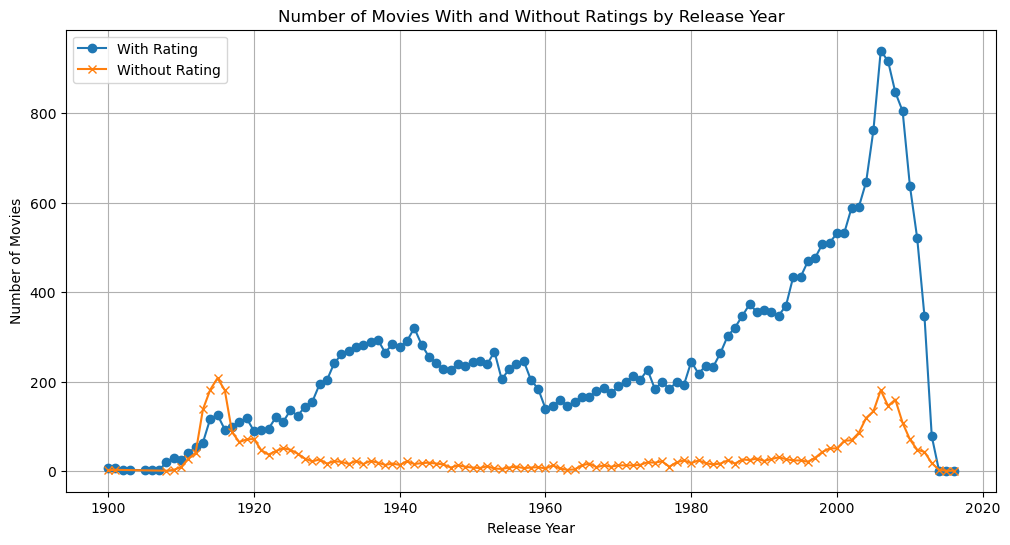

In [ ]:
# Group by release year and count movies with ratings
rat_per_year = rat.groupby('Movie release date')['averageRating'].count()

# Group by release year and count movies without ratings
no_rat_per_year = no_rat.groupby('Movie release date').size()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rat_per_year.index, rat_per_year.values, label='With Rating', marker='o')
plt.plot(no_rat_per_year.index, no_rat_per_year.values, label='Without Rating', marker='x')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies With and Without Ratings by Release Year')
plt.legend()
plt.grid()
plt.show()


We can see that there are a lot of movies without rating for years between 1912 and 1918 and later on around 2007. The first peak of missing ratings is quite problematic as there are more movies without rating than with, while the second is much less problematic since there are more movies that have a rating. 
We should take this into account later on when trying to draw conclusions. 

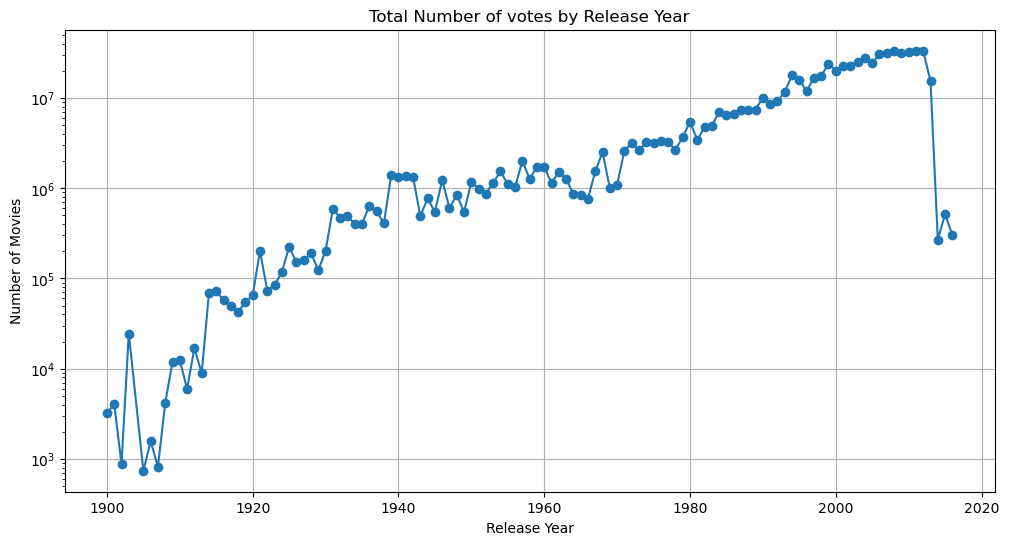

In [17]:
# Group by release year and count movies with ratings
votes_per_year = rat.groupby('Movie release date')['numVotes'].sum()


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(votes_per_year.index, votes_per_year.values, marker='o')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Total Number of votes by Release Year')
plt.grid()
plt.yscale('log')
plt.show()


Again we can see that the dataset is extremely inbalanced because we have far many votes for recent movies than before (NOTICE THE LOG SCALE)

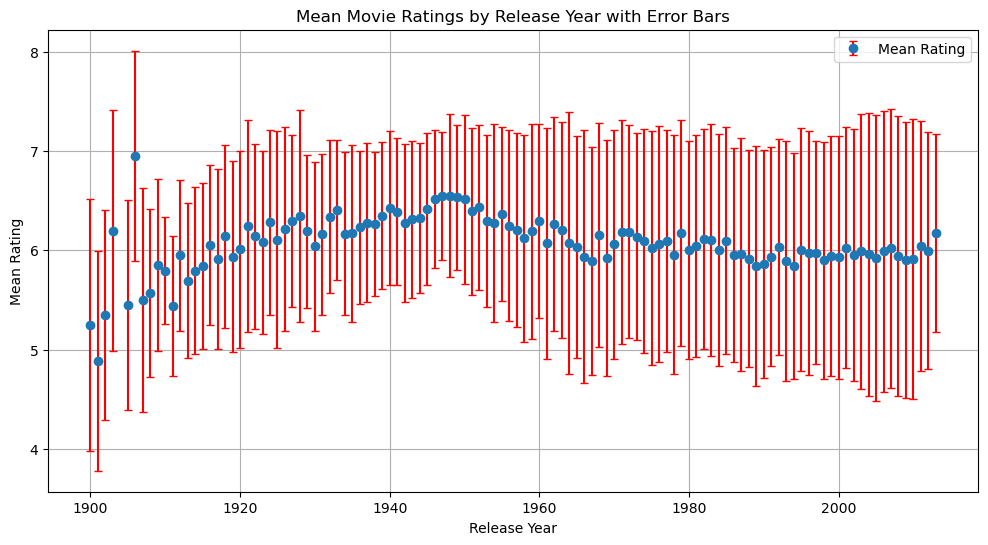

In [ ]:
# Group by release year and calculate mean and standard deviation
rating_stats = rat.groupby('Movie release date')['averageRating'].agg(['mean', 'std']).dropna()


# Extract years, means, and standard deviations
years = rating_stats.index
means = rating_stats['mean']
stds = rating_stats['std']

# Plot the mean ratings with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(years, means, yerr=stds, fmt='o', label='Mean Rating', ecolor='red', capsize=3)
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')
plt.title('Mean Movie Ratings by Release Year with Error Bars')
plt.legend()
plt.grid()
plt.show()

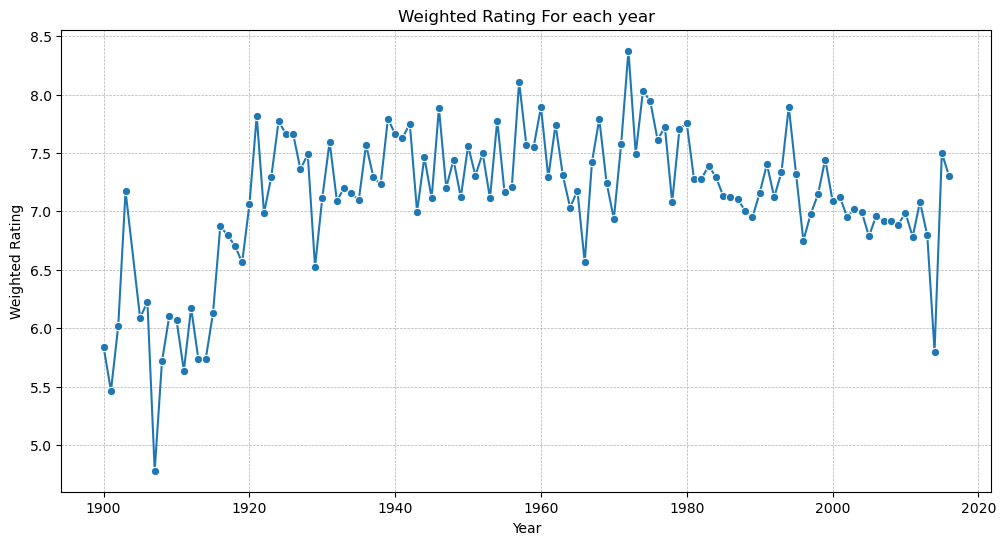

In [51]:
# Multiply rating by the number of votes for each movie
rat['rating_votes'] = rat['averageRating'] * rat['numVotes']

# Group by movie release year and calculate the mean of 'rating_votes'
average_rating_votes_per_year = rat.groupby('Movie release date')['rating_votes'].sum() / rat.groupby('Movie release date')['numVotes'].sum()

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(x=average_rating_votes_per_year.index, y=average_rating_votes_per_year.values, marker='o')

plt.xlabel('Year')
plt.ylabel('Weighted Rating')
plt.title('Weighted Rating For each year')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_14580\1863824064.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rating_quantiles = rat.groupby('Movie release date').apply(quantile_means)


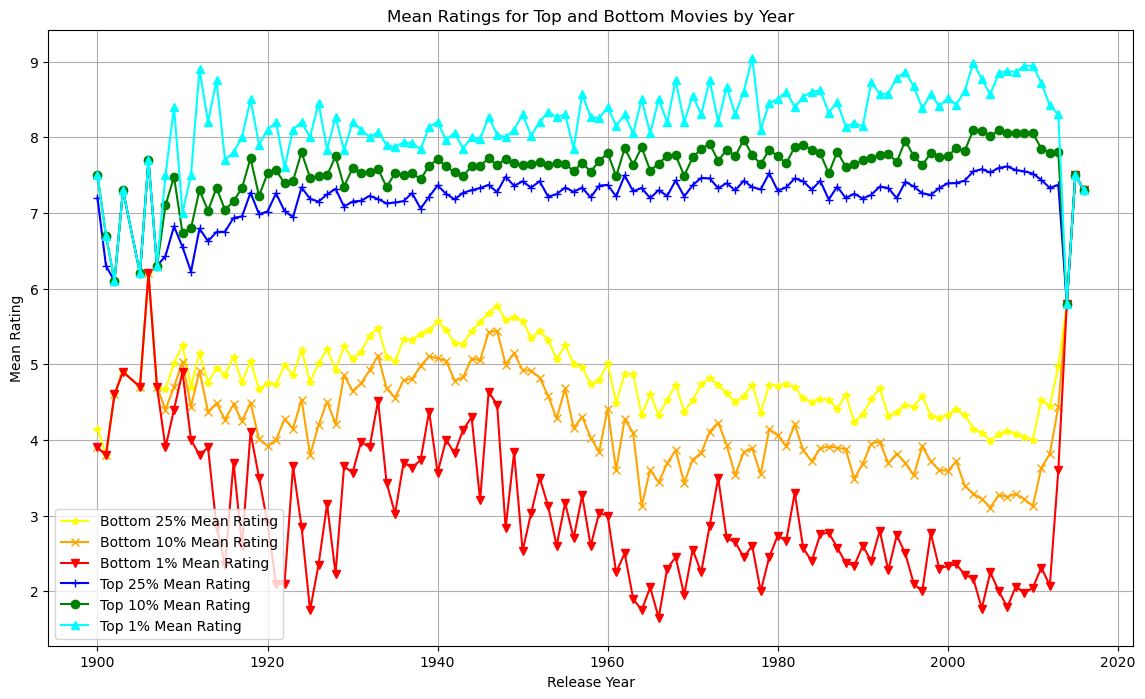

In [25]:
# Define a function to calculate mean for top 10%, bottom 10%, top 1%, and bottom 1%
def quantile_means(group):
    top_25_cutoff = group['averageRating'].quantile(0.75)  # Top 25% cutoff
    bottom_25_cutoff = group['averageRating'].quantile(0.25)  # Top 10% cutoff
    top_10_cutoff = group['averageRating'].quantile(0.9)  # Top 10% cutoff
    bottom_10_cutoff = group['averageRating'].quantile(0.1)  # Bottom 10% cutoff
    top_1_cutoff = group['averageRating'].quantile(0.99)  # Top 1% cutoff
    bottom_1_cutoff = group['averageRating'].quantile(0.01)  # Bottom 1% cutoff

    top_25_mean = group[group['averageRating'] >= top_25_cutoff]['averageRating'].mean()
    bottom_25_mean = group[group['averageRating'] <= bottom_25_cutoff]['averageRating'].mean()
    top_10_mean = group[group['averageRating'] >= top_10_cutoff]['averageRating'].mean()
    bottom_10_mean = group[group['averageRating'] <= bottom_10_cutoff]['averageRating'].mean()
    top_1_mean = group[group['averageRating'] >= top_1_cutoff]['averageRating'].mean()
    bottom_1_mean = group[group['averageRating'] <= bottom_1_cutoff]['averageRating'].mean()

    return pd.Series({
        'top_25_mean': top_25_mean,
        'bottom_25_mean': bottom_25_mean,
        'top_10_mean': top_10_mean,
        'bottom_10_mean': bottom_10_mean,
        'top_1_mean': top_1_mean,
        'bottom_1_mean': bottom_1_mean
    })

# Group by release year and apply the function
rating_quantiles = rat.groupby('Movie release date').apply(quantile_means)

# Extract years and the means
years = rating_quantiles.index
top_25_means = rating_quantiles['top_25_mean']
bottom_25_means = rating_quantiles['bottom_25_mean']
top_10_means = rating_quantiles['top_10_mean']
bottom_10_means = rating_quantiles['bottom_10_mean']
top_1_means = rating_quantiles['top_1_mean']
bottom_1_means = rating_quantiles['bottom_1_mean']

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(years, bottom_25_means, label='Bottom 25% Mean Rating', marker='*', color='yellow')
plt.plot(years, bottom_10_means, label='Bottom 10% Mean Rating', marker='x', color='orange')
plt.plot(years, bottom_1_means, label='Bottom 1% Mean Rating', marker='v', color='red')
plt.plot(years, top_25_means, label='Top 25% Mean Rating', marker='+', color='blue')
plt.plot(years, top_10_means, label='Top 10% Mean Rating', marker='o', color='green')
plt.plot(years, top_1_means, label='Top 1% Mean Rating', marker='^', color='cyan')
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings for Top and Bottom Movies by Year')
plt.legend()
plt.grid()
plt.show()

We can see that the best movies of each year are all following a similar trend and are quite stable. The bad ones on the other side are changing a lot over time, in a range of 10 years arounf 1940 there were a few very bad movies, while in the 60s there were a lot of bad movies, which turns the mean down. 

C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_25132\1788823380.py:20: RuntimeWarning: overflow encountered in power
  plt.plot(10**x_smooth, y_smooth, color='red', label="Degree 2 Polynomial Fit", linewidth=2)


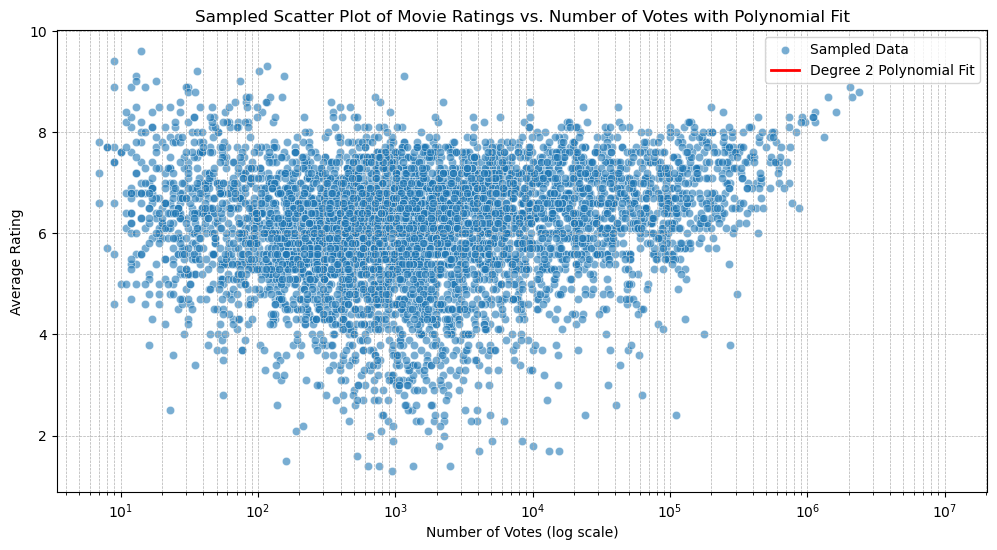

In [18]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Filter out rows where numVotes <= 0
sampled_rat = rat[rat['numVotes'] > 0].sample(frac=0.2, random_state=42)  # Sample 1% for better results

# Fit a degree-2 polynomial
x = sampled_rat['numVotes']
y = sampled_rat['averageRating']
coeffs = np.polyfit(x, y, deg=2)  # Fit polynomial of degree 2
poly = np.poly1d(coeffs)

# Generate smooth x values for plotting the polynomial
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = poly(x_smooth)

# Plot the scatterplot with the fitted polynomial
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sampled_rat, x='numVotes', y='averageRating', alpha=0.6, label="Sampled Data")
plt.plot(10**x_smooth, y_smooth, color='red', label="Degree 2 Polynomial Fit", linewidth=2)

# Set x-axis to log scale
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Sampled Scatter Plot of Movie Ratings vs. Number of Votes with Polynomial Fit')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_18084\634572651.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_stats = rat.groupby('logVotes_binned')['averageRating'].agg(['mean', 'std']).dropna()


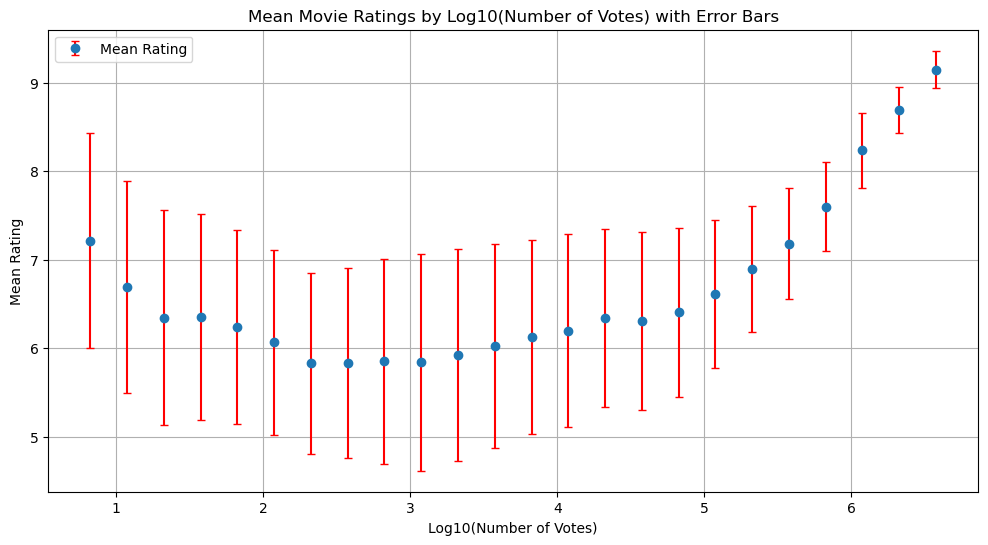

In [9]:
import numpy as np
import matplotlib.pyplot as plt

rat['logVotes'] = rat['numVotes'].apply(lambda x : np.log10(x))
#
# Define bins for logVotes
bins = np.arange(rat['logVotes'].min(), rat['logVotes'].max() + 0.5, 0.25)
labels = (bins[:-1] + bins[1:]) / 2  # Use the midpoint of each bin for plotting

# Assign each logVotes value to a bin
rat['logVotes_binned'] = pd.cut(rat['logVotes'], bins=bins, labels=labels, include_lowest=True)

# Group by binned logVotes and calculate mean and standard deviation
rating_stats = rat.groupby('logVotes_binned')['averageRating'].agg(['mean', 'std']).dropna()

# Extract binned logVotes (midpoints), means, and standard deviations
binned_logVotes = rating_stats.index.astype(float)
means = rating_stats['mean']
stds = rating_stats['std']

# Plot the mean ratings with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(binned_logVotes, means, yerr=stds, fmt='o', label='Mean Rating', ecolor='red', capsize=3)
plt.xlabel('Log10(Number of Votes)')
plt.ylabel('Mean Rating')
plt.title('Mean Movie Ratings by Log10(Number of Votes) with Error Bars')
plt.legend()
plt.grid()
plt.show()


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_14580\84646600.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=2)


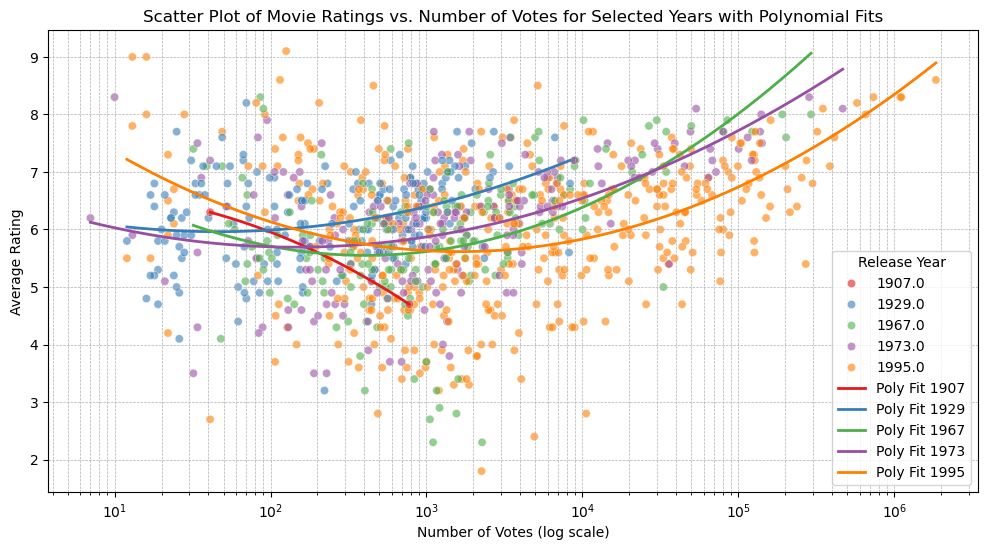

In [ ]:


# List of years to filter
selected_years = [1907, 1929, 1967, 1973, 1995]

# Filter the DataFrame to include only movies from the selected years
filtered_rat = rat[rat['Movie release date'].isin(selected_years)]

# Create a color palette based on the unique years
palette = sns.color_palette("Set1", n_colors=len(selected_years))

# Plot the scatterplot for the selected years with unique colors for each year
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_rat, x='numVotes', y='averageRating', 
                hue='Movie release date', palette=palette, alpha=0.6)

# Fit and plot a degree-2 polynomial for each selected year
for year in selected_years:
    # Filter the data for the current year
    year_data = filtered_rat[filtered_rat['Movie release date'] == year]
    
    # Log-transform 'numVotes' for better fitting in the log scale
    x = np.log10(year_data['numVotes'])
    y = year_data['averageRating']
    
    # Fit a degree-2 polynomial (quadratic)
    coeffs = np.polyfit(x, y, deg=2)
    poly = np.poly1d(coeffs)
    
    # Generate smooth x values for the fitted curve
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = poly(x_smooth)
    
    # Plot the polynomial curve
    plt.plot(10**x_smooth, y_smooth, label=f'Poly Fit {year}', color=palette[selected_years.index(year)], linewidth=2)

# Set log scale for x-axis
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Selected Years with Polynomial Fits')
plt.legend(title='Release Year')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


This graph is interesting, if we can make it usable in the website when people can select 2 (or more) years and compare them in this plot would be very nice (We don't absolutely need the polynomials, it was just to try to see the difference between the years) 

ALSO COMPARE TWO PERIODS -> MORE DATA TO VIZUALIZE

In [57]:
rat['Movie runtime'].describe()

count    2.671000e+04
mean     1.300422e+02
std      6.603466e+03
min      5.000000e-01
25%      8.000000e+01
50%      9.100000e+01
75%      1.030000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

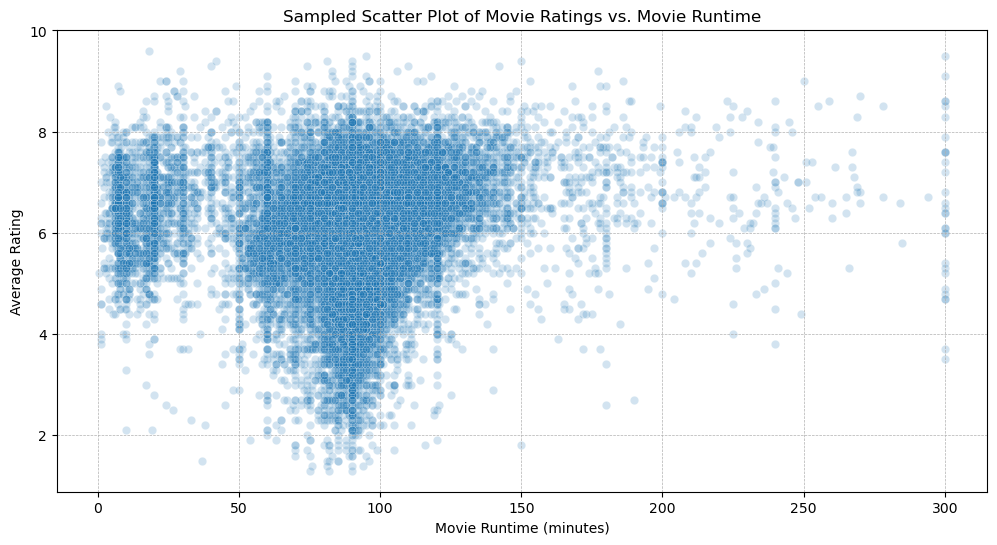

count    24023.000000
mean        89.294706
std         31.535132
min          0.500000
25%         80.000000
50%         91.000000
75%        102.000000
max        300.000000
Name: Movie runtime, dtype: float64

In [70]:
# Clip the values to be between 0 and 200
rat['Movie runtime'] = rat['Movie runtime'].clip(0, 300)

sampled_rat = rat.sample(frac=0.9, random_state=42)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=sampled_rat, x='Movie runtime', y='averageRating', alpha=0.2)
plt.xlabel('Movie Runtime (minutes)')
plt.xscale('linear')
plt.ylabel('Average Rating')
plt.title('Sampled Scatter Plot of Movie Ratings vs. Movie Runtime')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()
sampled_rat['Movie runtime'].describe()

Not really useful as a graph, can't make a lot out of it

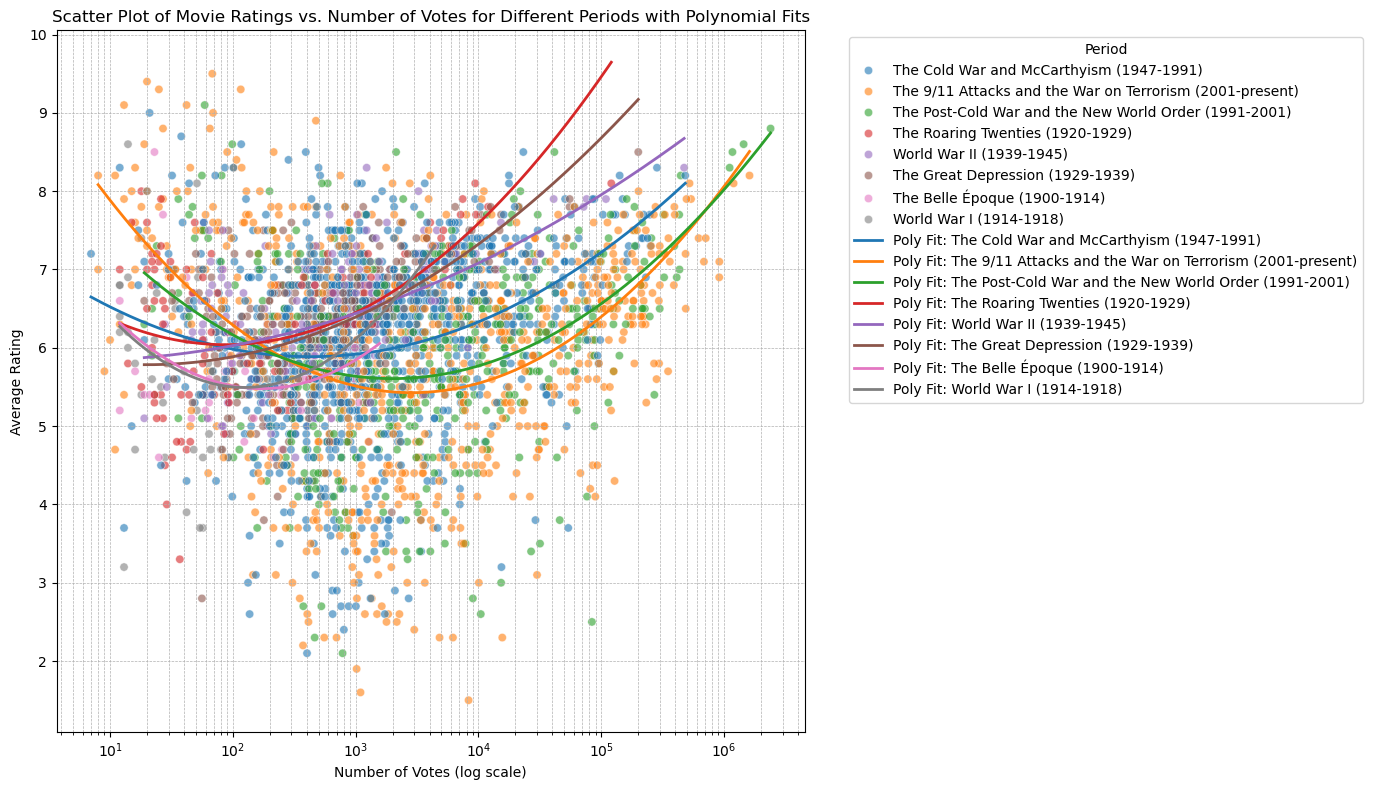

In [ ]:
periods_map = {
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1913},
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919},
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1928},
    "The Great Depression (1929-1939)": {"start_year": 1930, "end_year": 1939},
    "World War II (1939-1945)": {"start_year": 1940, "end_year": 1946},
    "Early Cold War (1947-1960)": {"start_year": 1947, "end_year": 1960},
    "The Civil Rights Movement (1960-1970)": {"start_year": 1961, "end_year": 1970},
    "Late Cold War (1971-1989)": {"start_year": 1971, "end_year": 1989},
    "End of the Cold War (1990-1991)": {"start_year": 1990, "end_year": 1991},
    "Post-Cold War and the New World Order (1992-2001)": {"start_year": 1992, "end_year": 2000},
    "War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024},
}
# Assign a period label to each movie based on its release year
def assign_period(year):
    for period, bounds in periods_map.items():
        if bounds["start_year"] <= year <= bounds["end_year"]:
            return period
    return None

# Add a 'Period' column to the DataFrame
rat['Period'] = rat['Movie release date'].apply(assign_period)

# Filter to include only movies in the defined periods
filtered_rat = rat[rat['Period'].notna()]
filtered_rat = filtered_rat.sample(frac=0.1)

# Create a color palette based on the unique periods
unique_periods = filtered_rat['Period'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_periods))

# Plot the scatterplot for the selected periods with unique colors for each period
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_rat, x='numVotes', y='averageRating', 
                hue='Period', palette=palette, alpha=0.6)

# Fit and plot a degree-2 polynomial for each period
for i, period in enumerate(unique_periods):
    # Filter the data for the current period
    period_data = filtered_rat[filtered_rat['Period'] == period]
    
    # Log-transform 'numVotes' for better fitting in the log scale
    x = np.log10(period_data['numVotes'])
    y = period_data['averageRating']
    
    # Fit a degree-2 polynomial (quadratic)
    if len(x) > 2:  # Ensure there are enough data points to fit a polynomial
        coeffs = np.polyfit(x, y, deg=2)
        poly = np.poly1d(coeffs)
        
        # Generate smooth x values for the fitted curve
        x_smooth = np.linspace(x.min(), x.max(), 500)
        y_smooth = poly(x_smooth)
        
        # Plot the polynomial curve
        plt.plot(10**x_smooth, y_smooth, label=f'Poly Fit: {period}', 
                 color=palette[i], linewidth=2)

# Set log scale for x-axis
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Different Periods with Polynomial Fits')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Cool result we can use to compare periods !

# a faire encore:

- ratings in fct of theme (when lilly-flore is done)

In [27]:
mov = pd.read_csv("data/processed_movies.csv")


movies_df_copy = mov.copy()

# Casefolding all the strings of column "Movie genres" the Data Frame
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(lambda x: x.casefold() if isinstance(x, str) else x)

# Transform string into a list of strings (word = genre)
def clean_genres(x):
    # If the value is a string (which contains the genres), clean it
    if isinstance(x, str):
        str_to_list = [genre.strip("'") for genre in x.strip("[]").split(", ")]
        #str_to_list = [genre for genre in str_to_list if genre not in unwanted_genres]
        return str_to_list if str_to_list else None
    # If it's already a list, return it as is
    elif isinstance(x, list):
        return x
    else:
        genres = []
    # Remove the row if the list is empty
    return genres if genres else None


# Clean the genres
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(clean_genres)

movies_df_copy['Movie genres']

# Clearer to put it this way: theme and its corresponding genres
theme_mapping = {
    'Action/Adventure/Thriller': ['action', 'thriller', 'adventure', 'action/adventure', 'fantasy adventure', 'adventure comedy', 'action comedy', 'action thrillers', 'spy', 'martial arts film'],
    'Comedy': ['comedy', 'parody','romantic comedy', 'buddy film','black comedy', 'slapstick', 'comedy-drama', 'comedy film', 'adventure comedy', 'screwball comedy', 'fantasy comedy', 'domestic comedy', 'comedy of manners', 'sex comedy', 'comedy of errors'],
    'Drama': ['drama', 'family drama','costume drama', 'melodrama', 'crime drama', 'political drama', 'comedy-drama', 'marriage drama', 'courtroom drama', 'historical fiction', 'political cinema', 'social issues', 'crime comedy'],
    'Romance': ['romance film', 'romantic comedy', 'romantic drama', 'romantic fantasy'],
    'Crime': ['crime fiction', 'crime thriller', 'gangster film', 'detective', 'detective fiction', 'crime drama', 'b-movie', 'heist'],
    'Horror': ['horror', 'slasher', 'psychological thriller', 'zombie film', 'horror comedy', 'monster movie', 'natural horror films', 'suspense'],
    'Science Fiction/Fantasy': ['science fiction','supernatural', 'fantasy', 'superhero movie', 'sci-fi horror', 'superhero', 'fantasy comedy'],
    'Historical/Biographical': ['period piece', 'biopic [feature]','historical drama', 'biography', 'history', 'biographical film', 'historical fiction'],
    'War': ['war film', 'military drama', 'combat film', 'anti-war film'],
    'Animation': ['animation', 'animated cartoon', 'computer animation', 'animated musical'],
    'Documentary': ['documentary', 'docudrama', 'rockumentary', 'concert film', 'mockumentary'],
    'Short': ['short film'],
    'Black-and-White': ['black-and-white'], 
    'Silent': ['silent film'],
    'Independent/Experimental': ['indie', 'experimental film'],
    'Youth/Family': ['family','family film', 'teen', '"children\'s/family"','"children\'s fantasy"', '"children\'s"', 'family-oriented adventure', "children\'s fantasy"],
    'Musical': ['musical', 'musical drama', 'musical comedy', 'music'],
    'LGBT': ['lgbt', 'gay', 'gay themed', 'gay interest'],
    'Western': ['western'],
    'Mystery/Detective': ['mystery', 'detective', 'detective fiction', 'film noir'],
    'Cult/Underground': ['cult', 'b-movie', 'experimental film'],
    'Epic/Adventure': ['epic', 'road movie', 'action/adventure', 'adventure comedy'],
    'Political/War': ['political thriller', 'war film', 'military drama', 'combat film', 'anti-war film'],
    'Other': []
}


# Inverting the theme_mapping to map genres to themes
genre_to_theme_mapping = {
    genre: theme
    for theme, genres in theme_mapping.items()
    for genre in genres
}

d = {}
# Function to map genres to themes
def map_genres_to_themes(genres, mapping):
    #print(genres)
    if isinstance(genres, list):
        themes = set()
        for genre in genres:
            if genre in mapping:
                themes.add(mapping[genre])
            else:
                if(genre in d.keys()):
                    d[genre] = d[genre] + 1
                else:
                    d[genre] = 0
                themes.add('Other')
        return themes
    elif isinstance(genres, str):
        if genres in mapping:
            return {mapping[genres]}
        else:
            return {'Other'}
    return None


movies_df_copy['Themes'] = movies_df_copy['Movie genres'].apply(lambda genres: map_genres_to_themes(genres, genre_to_theme_mapping))

periods_map = {
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1913},
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919},
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1928},
    "The Great Depression (1929-1939)": {"start_year": 1930, "end_year": 1939},
    "World War II (1939-1945)": {"start_year": 1940, "end_year": 1946},
    "Early Cold War (1947-1960)": {"start_year": 1947, "end_year": 1960},
    "The Civil Rights Movement (1960-1970)": {"start_year": 1961, "end_year": 1970},
    "Late Cold War (1971-1989)": {"start_year": 1971, "end_year": 1989},
    "End of the Cold War (1990-1991)": {"start_year": 1990, "end_year": 1991},
    "Post-Cold War and the New World Order (1992-2001)": {"start_year": 1992, "end_year": 2000},
    "War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024},
}
# Assign a period label to each movie based on its release year
def assign_period(year):
    for period, bounds in periods_map.items():
        if bounds["start_year"] <= year <= bounds["end_year"]:
            return period
    return None

# Add a 'Period' column to the DataFrame
movies_df_copy['Period'] = movies_df_copy['Movie release date'].apply(assign_period)



print(sorted( ((v,k) for k,v in d.items()), reverse=True))
#print(mov.head(5))
# Drop rows where Themes is NaN or empty
movies_df_copy = movies_df_copy.dropna(subset=['Themes'])

movies_df_copy.head(5)

[(1130, 'film adaptation'), (805, 'sports'), (778, 'television movie'), (587, 'coming of age'), (508, 'culture & society'), (425, 'satire'), (324, 'world cinema'), (293, 'ensemble film'), (273, 'creature film'), (223, 'disaster'), (217, 'japanese movies'), (174, 'pre-code'), (157, 'animal picture'), (139, 'propaganda film'), (137, 'erotic thriller'), (135, 'pornographic movie'), (128, 'christian film'), (104, 'americana'), (104, 'adult'), (98, 'doomsday film'), (95, 'swashbuckler films'), (95, 'blaxploitation'), (94, 'prison'), (88, 'chinese movies'), (88, 'alien film'), (87, 'stop motion'), (87, 'chase movie'), (86, 'new hollywood'), (84, 'holiday film'), (84, 'film'), (84, ''), (81, 'combat films'), (81, 'christmas movie'), (78, 'workplace comedy'), (78, 'sexploitation'), (75, 'stand-up comedy'), (75, 'remake'), (75, 'erotica'), (74, 'avant-garde'), (74, 'absurdism'), (73, 'dance'), (72, 'childhood drama'), (71, 'hip hop movies'), (70, 'time travel'), (70, 'monster'), (69, 'comedy th

,Wikipedia movie ID,freebase_ID,Movie name,Movie release date,Movie runtime,Movie languages,Movie countries,Movie genres,IMDB_ID,averageRating,numVotes,Themes,Period
0,975900,/m/03vyhn,Ghosts of Mars,2001,98.0,['English Language'],['United States of America'],"[thriller, science fiction, horror, adventure,...",tt0228333,4.9,58906.0,"{Science Fiction/Fantasy, Action/Adventure/Thr...",War on Terrorism (2001-present)
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,['English Language'],['United States of America'],"[mystery, biographical film, drama, crime drama]",tt0245916,6.1,77.0,"{Historical/Biographical, Drama, Crime, Myster...",Post-Cold War and the New World Order (1992-2001)
2,13696889,/m/03cfc81,The Gangsters,1913,35.0,"['Silent film', 'English Language']",['United States of America'],"[short film, silent film, indie, black-and-whi...",tt0002894,7.2,19.0,"{Silent, Short, Comedy, Black-and-White, Indep...",The Belle Époque (1900-1914)
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,106.0,['English Language'],['United States of America'],"[musical, comedy, black-and-white]",tt0029852,6.8,2356.0,"{Comedy, Black-and-White, Musical}",The Great Depression (1929-1939)
4,175026,/m/017n1p,Sarah and Son,1930,86.0,['English Language'],['United States of America'],"[drama, black-and-white]",tt0021335,5.4,356.0,"{Black-and-White, Drama}",The Great Depression (1929-1939)


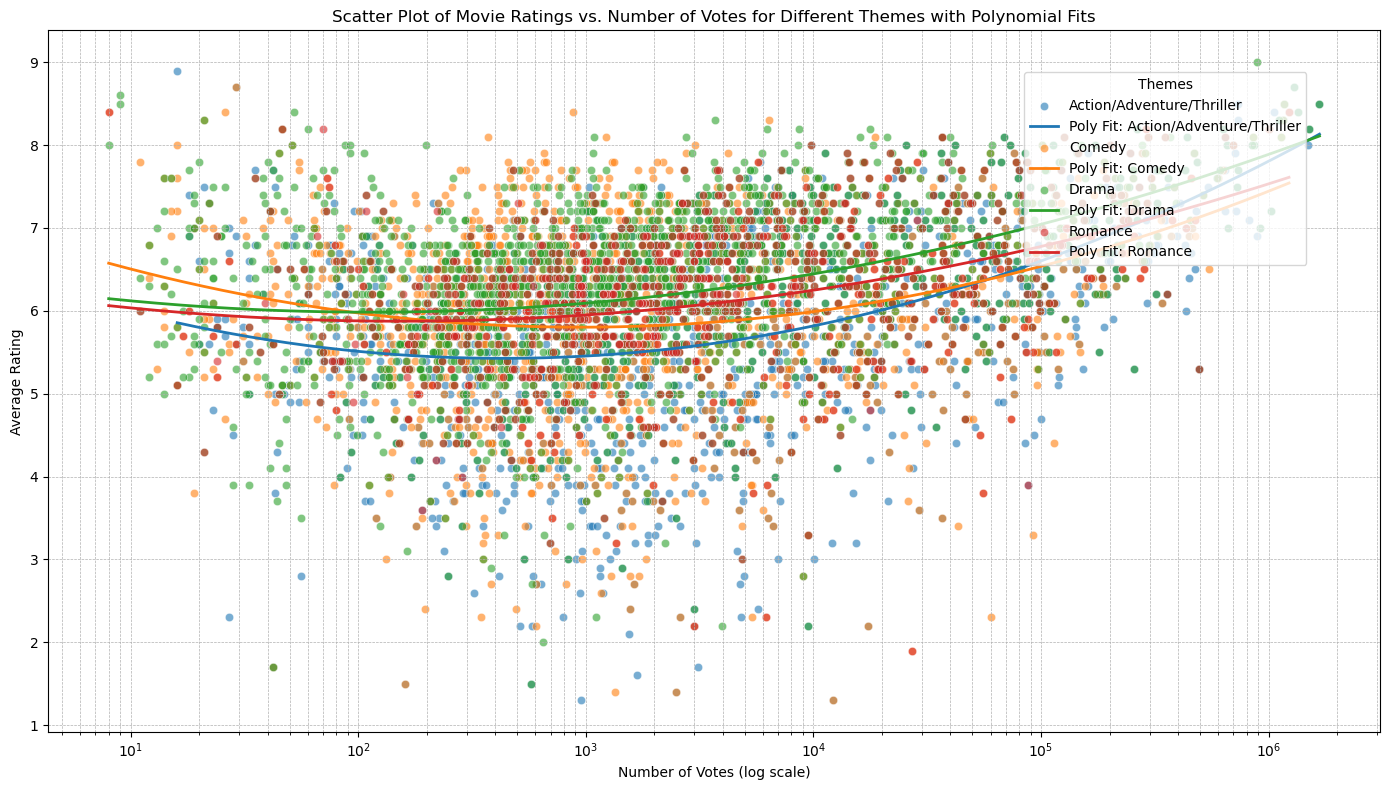

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_themes_with_fits(dataframe,ratio, themes_to_plot):
    """
    Plot a scatterplot of movie ratings vs. number of votes for specific themes,
    with polynomial fits and a legend inside the plot.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing movie data.
        themes_to_plot (list): A list of themes to plot.

    Returns:
        None
    """
    # Sample a subset of data for better visualization (optional)
    filtered_movies = dataframe.sample(frac=ratio, random_state=42)

    # Create a color palette based on the unique themes
    palette = sns.color_palette("tab10", n_colors=len(themes_to_plot))

    # Explode the Themes column
    filtered_movies = filtered_movies.explode('Themes')
    plt.figure(figsize=(14, 8))

    # Loop through each theme and plot points and polynomial fit
    for i, theme in enumerate(themes_to_plot):
        # Filter the data for the current theme
        theme_data = filtered_movies[filtered_movies['Themes'] == theme]

        # Drop invalid values
        theme_data = theme_data.dropna(subset=['numVotes', 'averageRating'])
        theme_data = theme_data[theme_data['numVotes'] > 0]  # Avoid log of non-positive values

        # Plot the scatter points for the current theme
        sns.scatterplot(
            data=theme_data,
            x='numVotes',
            y='averageRating',
            label=theme,
            color=palette[i],
            alpha=0.6
        )

        if len(theme_data) > 2:  # Ensure there are enough data points
            # Log-transform 'numVotes' for better fitting in the log scale
            x = np.log10(theme_data['numVotes'])
            y = theme_data['averageRating']

            try:
                # Fit a degree-2 polynomial (quadratic)
                coeffs = np.polyfit(x, y, deg=2)
                poly = np.poly1d(coeffs)

                # Generate smooth x values for the fitted curve
                x_smooth = np.linspace(x.min(), x.max(), 500)
                y_smooth = poly(x_smooth)

                # Plot the polynomial curve
                plt.plot(
                    10**x_smooth, 
                    y_smooth, 
                    label=f'Poly Fit: {theme}', 
                    color=palette[i], 
                    linewidth=2
                )
            except np.linalg.LinAlgError:
                print(f"Skipping theme {theme} due to numerical issues during fitting.")

    # Set log scale for x-axis
    plt.xscale('log')
    plt.xlabel('Number of Votes (log scale)')
    plt.ylabel('Average Rating')
    plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Different Themes with Polynomial Fits')

    # Add legend inside the plot
    plt.legend(title='Themes', loc='upper right', bbox_to_anchor=(0.95, 0.95))
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
ratio = 0.2
plot_themes_with_fits(movies_df_copy, ratio,['Action/Adventure/Thriller', 'Comedy', 'Drama', 'Romance'])


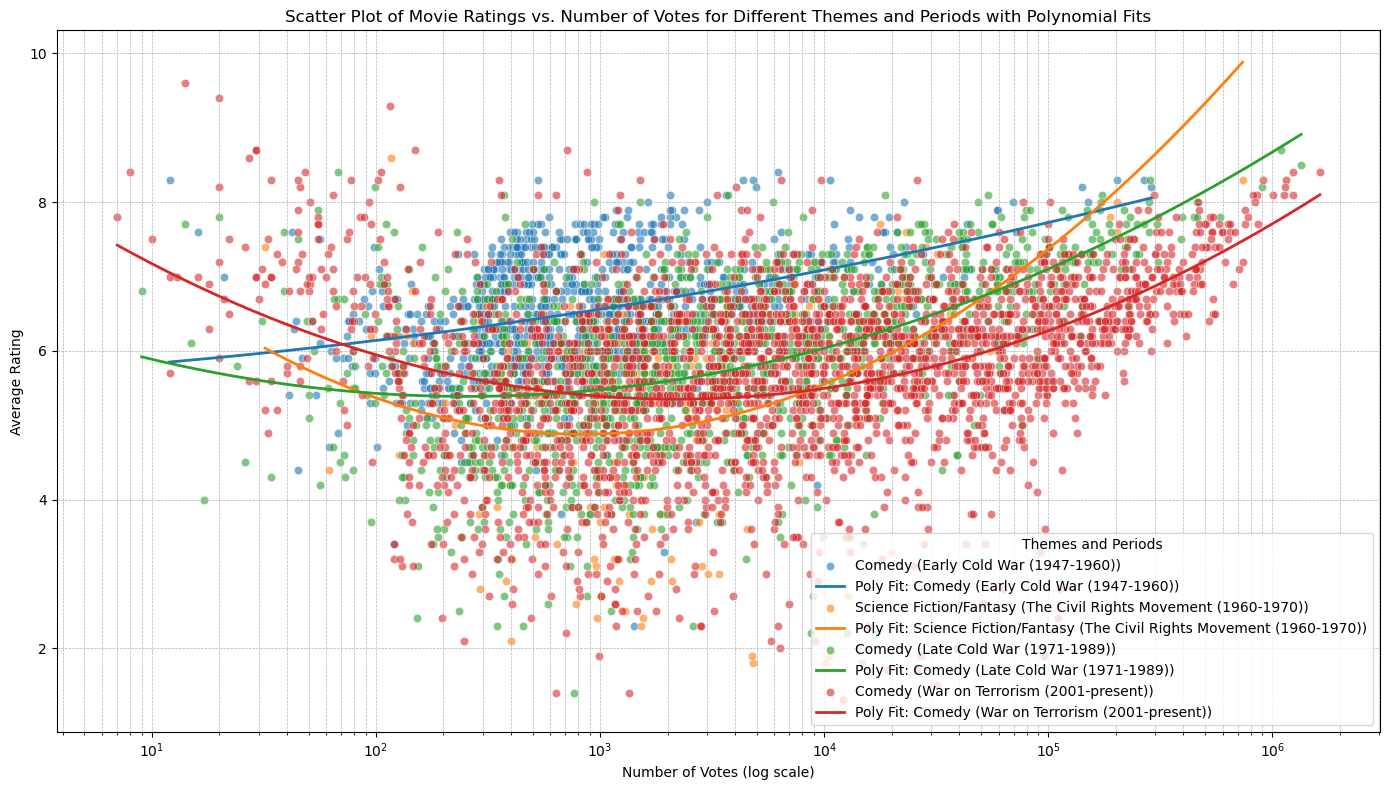

In [52]:
def plot_period_theme_with_fits(dataframe, selected_period_theme_pairs):
    """
    Plot a scatterplot of movie ratings vs. number of votes for specific themes and periods,
    with polynomial fits and a legend inside the plot.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing movie data.
        selected_period_theme_pairs (list of tuples): A list of (period, theme) pairs to plot.

    Returns:
        None
    """
    # Sample a subset of data for better visualization (optional)
    filtered_movies = dataframe.sample(frac=1, random_state=42)

    # Explode the Themes column
    filtered_movies = filtered_movies.explode('Themes')

    plt.figure(figsize=(14, 8))

    # Loop through each (period, theme) pair and plot points and polynomial fit
    for i, (period, theme) in enumerate(selected_period_theme_pairs):
        # Filter the data for the current period and theme
        theme_data = filtered_movies[(filtered_movies['Period'] == period) & (filtered_movies['Themes'] == theme)]

        # Drop invalid values
        theme_data = theme_data.dropna(subset=['numVotes', 'averageRating'])
        theme_data = theme_data[theme_data['numVotes'] > 0]  # Avoid log of non-positive values

        # Create a color palette
        palette = sns.color_palette("tab10", n_colors=len(selected_period_theme_pairs))

        # Plot the scatter points for the current period and theme
        sns.scatterplot(
            data=theme_data,
            x='numVotes',
            y='averageRating',
            label=f'{theme} ({period})',
            color=palette[i],
            alpha=0.6
        )

        if len(theme_data) > 2:  # Ensure there are enough data points
            # Log-transform 'numVotes' for better fitting in the log scale
            x = np.log10(theme_data['numVotes'])
            y = theme_data['averageRating']

            try:
                # Fit a degree-2 polynomial (quadratic)
                coeffs = np.polyfit(x, y, deg=2)
                poly = np.poly1d(coeffs)

                # Generate smooth x values for the fitted curve
                x_smooth = np.linspace(x.min(), x.max(), 500)
                y_smooth = poly(x_smooth)

                # Plot the polynomial curve
                plt.plot(
                    10**x_smooth, 
                    y_smooth, 
                    label=f'Poly Fit: {theme} ({period})', 
                    color=palette[i], 
                    linewidth=2
                )
            except np.linalg.LinAlgError:
                print(f"Skipping theme {theme} ({period}) due to numerical issues during fitting.")

    # Set log scale for x-axis
    plt.xscale('log')
    plt.xlabel('Number of Votes (log scale)')
    plt.ylabel('Average Rating')
    plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Different Themes and Periods with Polynomial Fits')

    # Add legend in the lower right part of the plot
    plt.legend(title='Themes and Periods', loc='lower right')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_period_theme_with_fits(movies_df_copy, [("The Great Depression (1929-1939)", "Comedy"), ("The Roaring Twenties (1920-1929)", "Comedy")])



selected_period_theme_pais = [("Early Cold War (1947-1960)", "Comedy"), ( "The Civil Rights Movement (1960-1970)", "Science Fiction/Fantasy"), ("Late Cold War (1971-1989)", "Comedy"),("War on Terrorism (2001-present)", "Comedy")]
plot_period_theme_with_fits(movies_df_copy, selected_period_theme_pais)



COMPARER LES FILMS DE Genre ABC d'une période avec un autre genre d'une autre période   
Rating par film par période

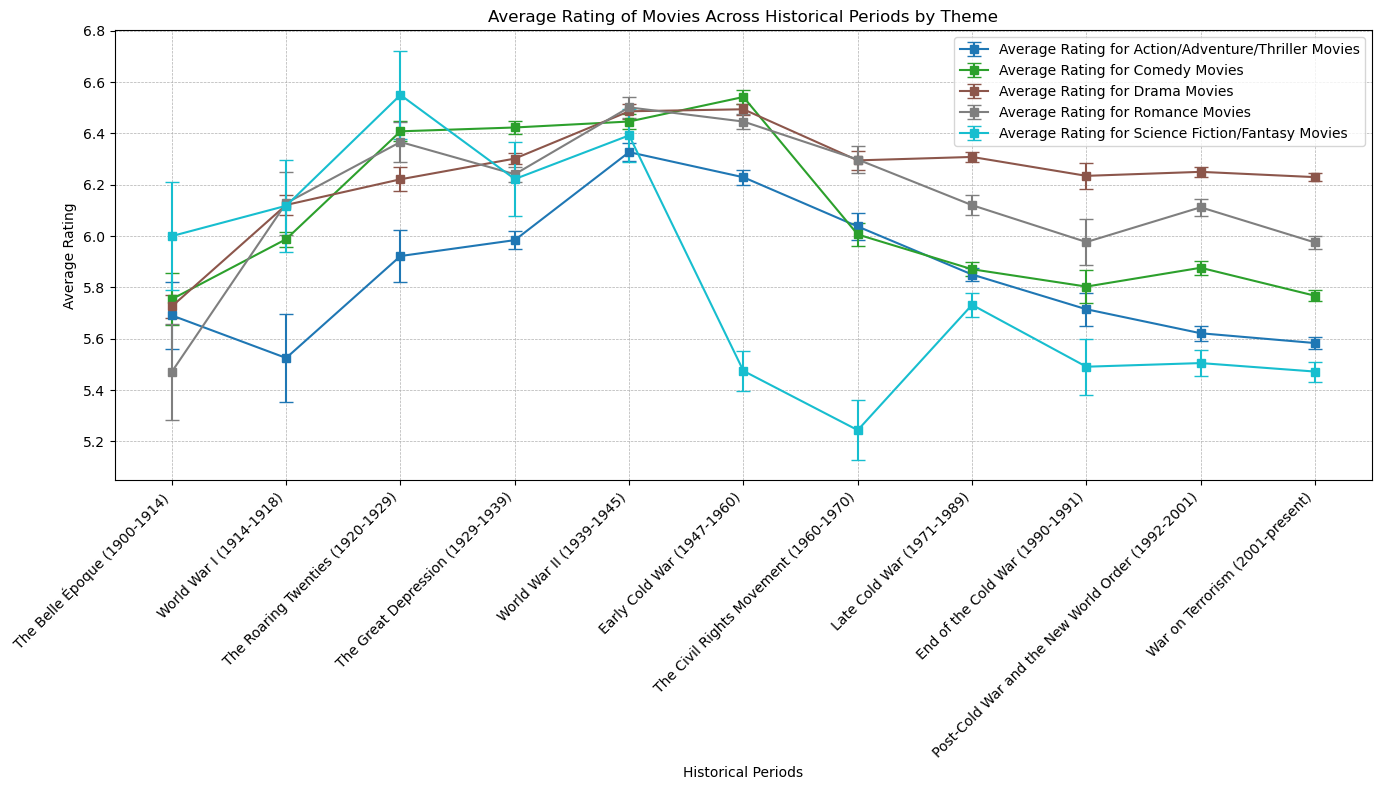

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_rating_by_period(dataframe, periods_map, themes):
    """
    Plot the average rating of movies for multiple themes across different historical periods using error bars.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing movie data.
        periods_map (dict): A dictionary mapping periods to their start and end years.
        themes (list): A list of themes to filter movies by.

    Returns:
        None
    """
    plt.figure(figsize=(14, 8))

    # Define a color palette for themes
    colors = plt.cm.tab10(np.linspace(0, 1, len(themes)))

    # Loop through each theme
    for theme, color in zip(themes, colors):
        period_names = []
        avg_ratings = []
        rating_errors = []

        # Loop through each period
        for period, years in periods_map.items():
            start_year = years["start_year"]
            end_year = years["end_year"]

            # Filter movies by the theme and period
            period_data = dataframe[dataframe["Period"] == period]
            period_data = period_data.explode('Themes')
            period_data = period_data[period_data['Themes'] == theme]

            if len(period_data) > 0:
                # Calculate average rating and standard error
                avg_rating = period_data['averageRating'].mean()
                rating_error = period_data['averageRating'].std() / np.sqrt(len(period_data))
            else:
                avg_rating = np.nan
                rating_error = np.nan

            # Append results
            period_names.append(period)
            avg_ratings.append(avg_rating)
            rating_errors.append(rating_error)

        # Plot the average ratings with error bars for the current theme
        plt.errorbar(
            x=period_names,
            y=avg_ratings,
            yerr=rating_errors,
            ecolor=color,
            capsize=5,
            linestyle='-',
            marker='s',
            color=color,
            label=f'Average Rating for {theme} Movies'
        )

    plt.xlabel('Historical Periods')
    plt.ylabel('Average Rating')
    plt.title(f'Average Rating of Movies Across Historical Periods by Theme')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_avg_rating_by_period(movies_df_copy, periods_map, ['Action/Adventure/Thriller', 'Comedy', 'Drama', 'Romance','Science Fiction/Fantasy'])
